# N04 - TFRecordsDataset Creation

- To meet the memory demand of point cloud dataset for large number of samples, the dataset has to be loaded lazily
- The `TFRecord` format is a simple format for storing a sequence of binary records with native support from tensorflow

### Loading Point Cloud data

- stored in parquet format and loaded as awkward arraays

In [1]:
import os
import re
import glob

input_dir = "/pscratch/sd/c/chlcheng/dataset/anomaly_detection/LHC_Olympics_2020/LHCO_RnD_qq/col_based"
regex = re.compile("point_cloud_W_qq_(?P<m1>[0-9]*)_(?P<m2>[0-9]*).parquet")
files = glob.glob(os.path.join(input_dir, "SR_*.parquet"))
filenames = {}
class_labels = {0: [], 1: []}
aux_features = {}
for file in files:
    if 'official' in file:
        continue
    match = regex.search(file)
    if not match:
        continue
    m1, m2 = match.group('m1'), match.group('m2')
    key = f"W_{m1}_{m2}"
    filenames[key] = file
    aux_features[key] = {"m1": float(m1), "m2": float(m2)}
    class_labels[1].append(key)
filenames['QCD'] = os.path.join(input_dir, "SR_point_cloud_QCD_qq.parquet")
filenames['extra_QCD'] = os.path.join(input_dir, "SR_point_cloud_extra_QCD_qq.parquet")
aux_features['QCD']       = {"m1": 0., "m2": 0.}
aux_features['extra_QCD'] = {"m1": 0., "m2": 0.}
class_labels[0] = ['QCD', 'extra_QCD']

In [2]:
import awkward as ak
import tensorflow as tf

print(f'awkward version     : {ak.__version__}')
print(f'tensorflow version  : {tf.__version__}')

2023-11-22 15:07:16.612980: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


awkward version     : 2.4.6
tensorflow version  : 2.12.1


In [3]:
from aliad.data import PointCloudDataset
feature_dict = {
        "part_coords"   : ["part_delta_eta", "part_delta_phi"],
        "part_features" : ["part_pt", "part_delta_eta", "part_delta_phi", "part_delta_R"],
        "jet_features"  : ["jet_pt", "jet_eta", "jet_phi", "jet_m", "N", "tau12", "tau23"] 
}
dataset = PointCloudDataset(class_labels=class_labels, feature_dict=feature_dict,
                            num_jets=2, pad_size=300, shuffle=False)

### Conversion to TFRecords

In [4]:
output_dir = "/pscratch/sd/c/chlcheng/dataset/anomaly_detection/LHC_Olympics_2020/LHCO_RnD_qq/tfrecords"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
outname = os.path.join(output_dir, 'SR_point_cloud_train_features_all_signals_all_backgrounds.tfrec')

In [9]:
dataset.convert_to_tfrecords(filenames, outname=outname, aux_features=aux_features)

[INFO] Created TFRecordWriter for the output "/pscratch/sd/c/chlcheng/dataset/anomaly_detection/LHC_Olympics_2020/LHCO_RnD_qq/tfrecords/SR_point_cloud_train_features_all_signals_all_backgrounds.tfrec"
[INFO] Writing to tfrecord for the sample "QCD"
[INFO] Loading dataset from "/pscratch/sd/c/chlcheng/dataset/anomaly_detection/LHC_Olympics_2020/LHCO_RnD_qq/col_based/SR_point_cloud_QCD_qq.parquet"
[INFO] Preparing data for the sample "QCD" (class = 0)
[INFO] Size of sample data: 121351
[INFO] Working on feature type "part_coords"
[INFO] Jet index: 1
[INFO] Loading data for the feature "part_delta_eta"
[INFO] Loading data for the feature "part_delta_phi"
[INFO] Jet index: 2
[INFO] Loading data for the feature "part_delta_eta"
[INFO] Loading data for the feature "part_delta_phi"
[INFO] Working on feature type "part_features"
[INFO] Jet index: 1
[INFO] Loading data for the feature "part_pt"
[INFO] Loading data for the feature "part_delta_eta"
[INFO] Loading data for the feature "part_delta_

### Load TFRecord Dataset

First we check the (custom made) metadata of the tfrecord dataset

In [6]:
import os
import json
import tensorflow as tf
from aliad.interface.tensorflow.dataset import get_ndarray_tfrecord_example_parser, get_feature_description
#outname = '/pscratch/sd/c/chlcheng/dataset/anomaly_detection/LHC_Olympics_2020/'
#          'LHCO_RnD_qq/tfrecords/SR_point_cloud_train_features_all_signals_all_backgrounds.tfrec'
metadata_filename = f'{os.path.splitext(outname)[0]}_metadata.json'
metadata = json.load(open(metadata_filename))

In [7]:
metadata['features']

{'part_coords': {'shape': [2, 300, 2], 'dtype': 'float64'},
 'part_features': {'shape': [2, 300, 4], 'dtype': 'float64'},
 'jet_features': {'shape': [2, 7], 'dtype': 'float64'},
 'part_masks': {'shape': [2, 300], 'dtype': 'bool'},
 'label': {'shape': [1], 'dtype': 'int64'},
 'weight': {'shape': [1], 'dtype': 'float64'},
 'm1': {'shape': [1], 'dtype': 'float64'},
 'm2': {'shape': [1], 'dtype': 'float64'}}

In [8]:
metadata['sample_size']

{'QCD': 121351,
 'extra_QCD': 612853,
 'W_50_450': 72728,
 'W_400_50': 44016,
 'W_500_600': 59319,
 'W_500_250': 68873,
 'W_350_500': 69686,
 'W_250_450': 72477,
 'W_450_350': 70912,
 'W_600_100': 48551,
 'W_50_100': 76327,
 'W_450_500': 67605,
 'W_100_400': 74261,
 'W_450_200': 70539,
 'W_600_300': 62038,
 'W_50_150': 76482,
 'W_500_500': 65754,
 'W_300_250': 74743,
 'W_450_600': 61071,
 'W_50_300': 75557,
 'W_200_500': 71231,
 'W_150_200': 76421,
 'W_500_50': 33154,
 'W_50_50': 75286,
 'W_150_300': 75953,
 'W_100_300': 75777,
 'W_400_450': 70527,
 'W_400_150': 70112,
 'W_100_500': 71493,
 'W_350_50': 49591,
 'W_250_150': 74473,
 'W_100_450': 73157,
 'W_350_250': 73947,
 'W_600_450': 60922,
 'W_150_400': 74239,
 'W_150_50': 70476,
 'W_50_500': 70855,
 'W_200_550': 68501,
 'W_250_600': 64278,
 'W_100_100': 76373,
 'W_400_550': 66384,
 'W_200_200': 75929,
 'W_150_600': 64707,
 'W_150_450': 72899,
 'W_300_500': 70313,
 'W_500_100': 58176,
 'W_550_50': 27970,
 'W_300_400': 73486,
 'W_100_

In [9]:
import numpy as np
total_size = np.sum([size for size in metadata['sample_size'].values()])
# total number of signal + background events passing preselection and SR selection
total_size

10508371

In [10]:
# method to parse each TFRecord
parse_tfrecord_fn = get_ndarray_tfrecord_example_parser(metadata['features'])
ds = tf.data.TFRecordDataset([outname], num_parallel_reads=tf.data.AUTOTUNE)
ds = ds.map(parse_tfrecord_fn, num_parallel_calls=tf.data.AUTOTUNE)

2023-11-22 15:08:18.249288: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 6991 MB memory:  -> device: 0, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:c3:00.0, compute capability: 8.0


In [11]:
# check the first event
data = list(ds.take(1))[0]
data

2023-11-22 15:08:20.629786: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1]
	 [[{{node Placeholder/_0}}]]
2023-11-22 15:08:20.630259: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1]
	 [[{{node Placeholder/_0}}]]


{'jet_features': <tf.Tensor: shape=(2, 7), dtype=float64, numpy=
 array([[ 1.55725584, -0.28612276, -0.44800308,  0.23789407, 29.        ,
          0.26323715,  0.7975898 ],
        [ 1.58957248,  0.31623674,  2.74671447,  0.03889603, 14.        ,
          0.58331666,  0.880918  ]])>,
 'label': <tf.Tensor: shape=(1,), dtype=int64, numpy=array([0])>,
 'm1': <tf.Tensor: shape=(1,), dtype=float64, numpy=array([0.])>,
 'm2': <tf.Tensor: shape=(1,), dtype=float64, numpy=array([0.])>,
 'part_coords': <tf.Tensor: shape=(2, 300, 2), dtype=float64, numpy=
 array([[[-0.19092877,  0.91749602],
         [ 0.56061639, -0.57879791],
         [ 0.18289359, -0.5255839 ],
         ...,
         [ 0.        ,  0.        ],
         [ 0.        ,  0.        ],
         [ 0.        ,  0.        ]],
 
        [[ 0.17166197,  0.89999813],
         [ 0.629498  , -0.62886441],
         [-0.05284388, -0.2330941 ],
         ...,
         [ 0.        ,  0.        ],
         [ 0.        ,  0.        ],
       

## Sharding TFRecordDataset
- Note that the TFRecordDataset we just created are not sorted and that loading a single large tfrecord file is not ideal for I/O performance
- So we split the dataset into multiple files (shards) with shuffling that ensures sample proportion (same S/B ratio in each file)

In [13]:
import os
import sys
import json
import numpy as np
# do not use GPU
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
import tensorflow as tf

from aliad.interface.tensorflow.dataset import (get_ndarray_tfrecord_example_parser, partition_dataset,
                                                select_dataset_by_index, tfds_to_tfrecords)
from aliad.data.partition import get_split_indices

outname = ('/pscratch/sd/c/chlcheng/dataset/anomaly_detection/LHC_Olympics_2020/'
          'LHCO_RnD_qq/tfrecords/SR_point_cloud_train_features_all_signals_all_backgrounds.tfrec')

metadata_filename = f'{os.path.splitext(outname)[0]}_metadata.json'
metadata = json.load(open(metadata_filename))
total_size = np.sum([size for size in metadata['sample_size'].values()])
total_size

10508371

In [14]:
size_per_shard = 100_000
split_sizes = [size_per_shard] * (total_size // size_per_shard) + [total_size % size_per_shard]
# number of shards
len(split_sizes)

106

Split the dataset in a stratified fashion (to make sure each mini-dataset has the correct S/B)

In [15]:
parse_tfrecord_fn = get_ndarray_tfrecord_example_parser(metadata['features'])
ds = tf.data.TFRecordDataset([outname], num_parallel_reads=tf.data.AUTOTUNE)
ds = ds.map(parse_tfrecord_fn, num_parallel_calls=tf.data.AUTOTUNE)
ds_label = ds.map(lambda x: x['label'])
stratify = np.array(list(ds_label))

2023-11-22 15:16:45.731810: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1]
	 [[{{node Placeholder/_0}}]]
2023-11-22 15:16:45.732009: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1]
	 [[{{node Placeholder/_0}}]]


In [16]:
stratify

array([[0],
       [0],
       [0],
       ...,
       [1],
       [1],
       [1]])

In [17]:
split_indices = get_split_indices(total_size, split_sizes=split_sizes,
                                  stratify=stratify, shuffle=True, seed=2023)

In [18]:
split_indices

{0: array([5883228, 5140274, 2699029, ..., 5440910, 7050955, 7171914]),
 1: array([1085407, 3233575, 3731383, ..., 7322936, 2371759,  104873]),
 2: array([6190419, 5632359, 9348902, ..., 9635716, 3048838, 5721439]),
 3: array([ 5022641,  5429268, 10091360, ...,  8676643,  9176004,  3820236]),
 4: array([7531729, 1455145, 6126565, ..., 4563993, 1931170,  109577]),
 5: array([9534631, 8303653, 3488264, ..., 9352154, 4772235, 4701487]),
 6: array([6413166, 7281521, 4024784, ...,  978926, 1061500, 6231393]),
 7: array([6916024, 9056058, 3963740, ..., 8529591, 4502174, 1915001]),
 8: array([1080641, 2318993, 5648349, ...,  460657, 1186998, 8847200]),
 9: array([  968051,  6147402, 10200275, ...,  8641751,  8614430,   213939]),
 10: array([6684686, 4516054, 6258544, ..., 3182664, 2271906, 2183257]),
 11: array([  136495,  6208416,  6694046, ..., 10404875,  1742718,  6162874]),
 12: array([4949391, 3362434, 3717157, ..., 4988296, 6226643, 7147627]),
 13: array([5511378, 2163159, 9809768, ...,

In [19]:
from quickstats.utils.common_utils import NpEncoder
# save the split indices so that we can reuse it later
index_outname = os.path.join(os.path.dirname(outname), 'split_index.json')
with open(index_outname, 'w') as f:
    json.dump(split_indices, f, cls=NpEncoder)

### Partition dataset

- To speed up the process, multiprocessing is used

In [20]:
import os
import sys
import json
import numpy as np
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
import tensorflow as tf
from aliad.interface.tensorflow.dataset import (get_ndarray_tfrecord_example_parser, 
                                                select_dataset_by_index, tfds_to_tfrecords)

from quickstats.utils.common_utils import execute_multi_tasks

def run_batch(batch_number:int, cache:bool=True, seed:int=2023):
    outname = ('/pscratch/sd/c/chlcheng/dataset/anomaly_detection/LHC_Olympics_2020/LHCO_RnD_qq/'
               'tfrecords/SR_point_cloud_train_features_all_signals_all_backgrounds.tfrec')
    index_outname = os.path.join(os.path.dirname(outname), 'split_index.json')
    metadata_filename = f'{os.path.splitext(outname)[0]}_metadata.json'
    metadata = json.load(open(metadata_filename))
    index_data = json.load(open(index_outname))
    indices = index_data[str(batch_number)]

    parse_tfrecord_fn = get_ndarray_tfrecord_example_parser(metadata['features'])
    ds = tf.data.TFRecordDataset([outname], num_parallel_reads=tf.data.AUTOTUNE)
    ds = ds.map(parse_tfrecord_fn, num_parallel_calls=tf.data.AUTOTUNE)
    ds_i = select_dataset_by_index(ds, indices)
    ds_i = ds_i.shuffle(buffer_size = len(indices), seed=seed + batch_number,
                        reshuffle_each_iteration=False)
    
    sys.stdout.write(f'INFO: Working on shard {batch_number + 1}\n')
    outname_i = f'{os.path.splitext(outname)[0]}_shuffled_shard_{batch_number}.tfrec'
    metadata_outname_i = f'{os.path.splitext(outname)[0]}_shuffled_shard_{batch_number}_metadata.json'
    if os.path.exists(metadata_outname_i) and cache:
        sys.stdout.write(f'INFO: Cached existing shard {outname_i}\n')
        return None
    metadata = tfds_to_tfrecords(ds_i, outname_i)
    with open(metadata_outname_i, 'w') as f:
        json.dump(metadata, f, indent=2)

In [21]:
execute_multi_tasks(run_batch, numbers, parallel=16)

2023-11-22 00:46:33.462152: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:266] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2023-11-22 00:46:33.477706: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:266] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2023-11-22 00:46:33.479344: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:266] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2023-11-22 00:46:33.508456: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:266] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2023-11-22 00:46:33.508740: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:266] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2023-11-22 00:46:33.528496: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:266] failed call to cuInit: CUDA_ER

INFO: Working on shard 20
INFO: Working on shard 14
INFO: Working on shard 2
INFO: Cached existing shard /pscratch/sd/c/chlcheng/dataset/anomaly_detection/LHC_Olympics_2020/LHCO_RnD_qq/tfrecords/SR_point_cloud_train_features_all_signals_all_backgrounds_shuffled_shard_19.tfrec
INFO: Cached existing shard /pscratch/sd/c/chlcheng/dataset/anomaly_detection/LHC_Olympics_2020/LHCO_RnD_qq/tfrecords/SR_point_cloud_train_features_all_signals_all_backgrounds_shuffled_shard_13.tfrec
INFO: Cached existing shard /pscratch/sd/c/chlcheng/dataset/anomaly_detection/LHC_Olympics_2020/LHCO_RnD_qq/tfrecords/SR_point_cloud_train_features_all_signals_all_backgrounds_shuffled_shard_1.tfrec
INFO: Working on shard 13
INFO: Cached existing shard /pscratch/sd/c/chlcheng/dataset/anomaly_detection/LHC_Olympics_2020/LHCO_RnD_qq/tfrecords/SR_point_cloud_train_features_all_signals_all_backgrounds_shuffled_shard_12.tfrec
INFO: Working on shard 4
INFO: Cached existing shard /pscratch/sd/c/chlcheng/dataset/anomaly_detec

2023-11-22 00:46:34.550648: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization
2023-11-22 00:46:34.550652: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization
2023-11-22 00:46:34.585699: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization
2023-11-22 00:46:34.601352: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization
2023-11-22 00:46:34.601959: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization
2023-11-22 00:46:34.610537: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization
2023-11-22 00:46:34.612049: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization
2023-11-22 00:46:34.621889: I tensorflow/

INFO: Working on shard 10
INFO: Cached existing shard /pscratch/sd/c/chlcheng/dataset/anomaly_detection/LHC_Olympics_2020/LHCO_RnD_qq/tfrecords/SR_point_cloud_train_features_all_signals_all_backgrounds_shuffled_shard_9.tfrec
INFO: Working on shard 17
INFO: Cached existing shard /pscratch/sd/c/chlcheng/dataset/anomaly_detection/LHC_Olympics_2020/LHCO_RnD_qq/tfrecords/SR_point_cloud_train_features_all_signals_all_backgrounds_shuffled_shard_16.tfrec
INFO: Working on shard 3
INFO: Cached existing shard /pscratch/sd/c/chlcheng/dataset/anomaly_detection/LHC_Olympics_2020/LHCO_RnD_qq/tfrecords/SR_point_cloud_train_features_all_signals_all_backgrounds_shuffled_shard_2.tfrec
INFO: Working on shard 16
INFO: Cached existing shard /pscratch/sd/c/chlcheng/dataset/anomaly_detection/LHC_Olympics_2020/LHCO_RnD_qq/tfrecords/SR_point_cloud_train_features_all_signals_all_backgrounds_shuffled_shard_15.tfrec
INFO: Working on shard 12
INFO: Cached existing shard /pscratch/sd/c/chlcheng/dataset/anomaly_detec

2023-11-22 00:46:35.549685: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization
2023-11-22 00:46:35.558289: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization
2023-11-22 00:46:35.561230: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization
2023-11-22 00:46:35.574611: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization
2023-11-22 00:46:35.599520: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization
2023-11-22 00:46:35.634241: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization
2023-11-22 00:46:35.640308: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization
2023-11-22 00:46:35.678808: I tensorflow/

INFO: Working on shard 32
INFO: Cached existing shard /pscratch/sd/c/chlcheng/dataset/anomaly_detection/LHC_Olympics_2020/LHCO_RnD_qq/tfrecords/SR_point_cloud_train_features_all_signals_all_backgrounds_shuffled_shard_31.tfrec
INFO: Working on shard 33
INFO: Cached existing shard /pscratch/sd/c/chlcheng/dataset/anomaly_detection/LHC_Olympics_2020/LHCO_RnD_qq/tfrecords/SR_point_cloud_train_features_all_signals_all_backgrounds_shuffled_shard_32.tfrec
INFO: Working on shard 21
INFO: Cached existing shard /pscratch/sd/c/chlcheng/dataset/anomaly_detection/LHC_Olympics_2020/LHCO_RnD_qq/tfrecords/SR_point_cloud_train_features_all_signals_all_backgrounds_shuffled_shard_20.tfrec
INFO: Working on shard 36
INFO: Working on shard 31
INFO: Cached existing shard /pscratch/sd/c/chlcheng/dataset/anomaly_detection/LHC_Olympics_2020/LHCO_RnD_qq/tfrecords/SR_point_cloud_train_features_all_signals_all_backgrounds_shuffled_shard_35.tfrec
INFO: Cached existing shard /pscratch/sd/c/chlcheng/dataset/anomaly_de

2023-11-22 00:46:35.764087: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization
2023-11-22 00:46:35.774648: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization
2023-11-22 00:46:35.784300: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization
2023-11-22 00:46:35.827608: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization
2023-11-22 00:46:35.857282: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization
2023-11-22 00:46:35.871184: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization
2023-11-22 00:46:35.910101: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization


INFO: Working on shard 28
INFO: Cached existing shard /pscratch/sd/c/chlcheng/dataset/anomaly_detection/LHC_Olympics_2020/LHCO_RnD_qq/tfrecords/SR_point_cloud_train_features_all_signals_all_backgrounds_shuffled_shard_27.tfrec
INFO: Working on shard 39
INFO: Cached existing shard /pscratch/sd/c/chlcheng/dataset/anomaly_detection/LHC_Olympics_2020/LHCO_RnD_qq/tfrecords/SR_point_cloud_train_features_all_signals_all_backgrounds_shuffled_shard_38.tfrec
INFO: Working on shard 27
INFO: Cached existing shard /pscratch/sd/c/chlcheng/dataset/anomaly_detection/LHC_Olympics_2020/LHCO_RnD_qq/tfrecords/SR_point_cloud_train_features_all_signals_all_backgrounds_shuffled_shard_26.tfrec
INFO: Working on shard 40
INFO: Cached existing shard /pscratch/sd/c/chlcheng/dataset/anomaly_detection/LHC_Olympics_2020/LHCO_RnD_qq/tfrecords/SR_point_cloud_train_features_all_signals_all_backgrounds_shuffled_shard_39.tfrec
INFO: Working on shard 34
INFO: Cached existing shard /pscratch/sd/c/chlcheng/dataset/anomaly_de

2023-11-22 00:46:36.482424: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization
2023-11-22 00:46:36.515461: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization
2023-11-22 00:46:36.522562: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization
2023-11-22 00:46:36.555986: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization
2023-11-22 00:46:36.632079: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization


INFO: Working on shard 46
INFO: Cached existing shard /pscratch/sd/c/chlcheng/dataset/anomaly_detection/LHC_Olympics_2020/LHCO_RnD_qq/tfrecords/SR_point_cloud_train_features_all_signals_all_backgrounds_shuffled_shard_45.tfrec
INFO: Working on shard 48
INFO: Cached existing shard /pscratch/sd/c/chlcheng/dataset/anomaly_detection/LHC_Olympics_2020/LHCO_RnD_qq/tfrecords/SR_point_cloud_train_features_all_signals_all_backgrounds_shuffled_shard_47.tfrec
INFO: Working on shard 47
INFO: Cached existing shard /pscratch/sd/c/chlcheng/dataset/anomaly_detection/LHC_Olympics_2020/LHCO_RnD_qq/tfrecords/SR_point_cloud_train_features_all_signals_all_backgrounds_shuffled_shard_46.tfrec
INFO: Working on shard 49
INFO: Cached existing shard /pscratch/sd/c/chlcheng/dataset/anomaly_detection/LHC_Olympics_2020/LHCO_RnD_qq/tfrecords/SR_point_cloud_train_features_all_signals_all_backgrounds_shuffled_shard_48.tfrec
INFO: Working on shard 50
INFO: Cached existing shard /pscratch/sd/c/chlcheng/dataset/anomaly_de

2023-11-22 00:46:36.731050: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization
2023-11-22 00:46:36.737284: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization
2023-11-22 00:46:36.759020: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization
2023-11-22 00:46:36.778241: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization
2023-11-22 00:46:36.845362: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization
2023-11-22 00:46:36.898398: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization
2023-11-22 00:46:36.902177: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization
2023-11-22 00:46:36.912974: I tensorflow/

INFO: Working on shard 54
INFO: Cached existing shard /pscratch/sd/c/chlcheng/dataset/anomaly_detection/LHC_Olympics_2020/LHCO_RnD_qq/tfrecords/SR_point_cloud_train_features_all_signals_all_backgrounds_shuffled_shard_53.tfrec
INFO: Working on shard 55
INFO: Cached existing shard /pscratch/sd/c/chlcheng/dataset/anomaly_detection/LHC_Olympics_2020/LHCO_RnD_qq/tfrecords/SR_point_cloud_train_features_all_signals_all_backgrounds_shuffled_shard_54.tfrec
INFO: Working on shard 51
INFO: Cached existing shard /pscratch/sd/c/chlcheng/dataset/anomaly_detection/LHC_Olympics_2020/LHCO_RnD_qq/tfrecords/SR_point_cloud_train_features_all_signals_all_backgrounds_shuffled_shard_50.tfrec
INFO: Working on shard 52
INFO: Cached existing shard /pscratch/sd/c/chlcheng/dataset/anomaly_detection/LHC_Olympics_2020/LHCO_RnD_qq/tfrecords/SR_point_cloud_train_features_all_signals_all_backgrounds_shuffled_shard_51.tfrec
INFO: Working on shard 53
INFO: Cached existing shard /pscratch/sd/c/chlcheng/dataset/anomaly_de

2023-11-22 00:46:36.946220: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization
2023-11-22 00:46:36.957859: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization
2023-11-22 00:46:37.058286: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization
2023-11-22 00:46:37.070365: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization
2023-11-22 00:46:37.133688: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization
2023-11-22 00:46:37.142294: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization


INFO: Working on shard 56
INFO: Cached existing shard /pscratch/sd/c/chlcheng/dataset/anomaly_detection/LHC_Olympics_2020/LHCO_RnD_qq/tfrecords/SR_point_cloud_train_features_all_signals_all_backgrounds_shuffled_shard_55.tfrec
INFO: Working on shard 57
INFO: Cached existing shard /pscratch/sd/c/chlcheng/dataset/anomaly_detection/LHC_Olympics_2020/LHCO_RnD_qq/tfrecords/SR_point_cloud_train_features_all_signals_all_backgrounds_shuffled_shard_56.tfrec
INFO: Working on shard 59
INFO: Cached existing shard /pscratch/sd/c/chlcheng/dataset/anomaly_detection/LHC_Olympics_2020/LHCO_RnD_qq/tfrecords/SR_point_cloud_train_features_all_signals_all_backgrounds_shuffled_shard_58.tfrec
INFO: Working on shard 58
INFO: Cached existing shard /pscratch/sd/c/chlcheng/dataset/anomaly_detection/LHC_Olympics_2020/LHCO_RnD_qq/tfrecords/SR_point_cloud_train_features_all_signals_all_backgrounds_shuffled_shard_57.tfrec
INFO: Working on shard 60
INFO: Cached existing shard /pscratch/sd/c/chlcheng/dataset/anomaly_de

2023-11-22 00:46:37.175644: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization


INFO: Working on shard 61
INFO: Cached existing shard /pscratch/sd/c/chlcheng/dataset/anomaly_detection/LHC_Olympics_2020/LHCO_RnD_qq/tfrecords/SR_point_cloud_train_features_all_signals_all_backgrounds_shuffled_shard_60.tfrec
INFO: Working on shard 62
INFO: Cached existing shard /pscratch/sd/c/chlcheng/dataset/anomaly_detection/LHC_Olympics_2020/LHCO_RnD_qq/tfrecords/SR_point_cloud_train_features_all_signals_all_backgrounds_shuffled_shard_61.tfrec
INFO: Working on shard 63
INFO: Cached existing shard /pscratch/sd/c/chlcheng/dataset/anomaly_detection/LHC_Olympics_2020/LHCO_RnD_qq/tfrecords/SR_point_cloud_train_features_all_signals_all_backgrounds_shuffled_shard_62.tfrec
INFO: Working on shard 64


2023-11-22 00:46:37.417240: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization
2023-11-22 00:46:37.440445: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization
2023-11-22 00:46:37.463317: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization
2023-11-22 00:46:37.490854: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization
2023-11-22 00:46:37.570150: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization


INFO: Cached existing shard /pscratch/sd/c/chlcheng/dataset/anomaly_detection/LHC_Olympics_2020/LHCO_RnD_qq/tfrecords/SR_point_cloud_train_features_all_signals_all_backgrounds_shuffled_shard_63.tfrec
INFO: Working on shard 65
INFO: Cached existing shard /pscratch/sd/c/chlcheng/dataset/anomaly_detection/LHC_Olympics_2020/LHCO_RnD_qq/tfrecords/SR_point_cloud_train_features_all_signals_all_backgrounds_shuffled_shard_64.tfrec
INFO: Working on shard 67
INFO: Cached existing shard /pscratch/sd/c/chlcheng/dataset/anomaly_detection/LHC_Olympics_2020/LHCO_RnD_qq/tfrecords/SR_point_cloud_train_features_all_signals_all_backgrounds_shuffled_shard_66.tfrec
INFO: Working on shard 68
INFO: Cached existing shard /pscratch/sd/c/chlcheng/dataset/anomaly_detection/LHC_Olympics_2020/LHCO_RnD_qq/tfrecords/SR_point_cloud_train_features_all_signals_all_backgrounds_shuffled_shard_67.tfrec
INFO: Working on shard 66
INFO: Cached existing shard /pscratch/sd/c/chlcheng/dataset/anomaly_detection/LHC_Olympics_2020/

2023-11-22 00:46:37.694822: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization
2023-11-22 00:46:37.714762: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization
2023-11-22 00:46:37.736511: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization
2023-11-22 00:46:37.797098: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization
2023-11-22 00:46:37.862345: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization
2023-11-22 00:46:37.875864: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization
2023-11-22 00:46:37.882385: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization


INFO: Working on shard 69
INFO: Cached existing shard /pscratch/sd/c/chlcheng/dataset/anomaly_detection/LHC_Olympics_2020/LHCO_RnD_qq/tfrecords/SR_point_cloud_train_features_all_signals_all_backgrounds_shuffled_shard_68.tfrec
INFO: Working on shard 72
INFO: Cached existing shard /pscratch/sd/c/chlcheng/dataset/anomaly_detection/LHC_Olympics_2020/LHCO_RnD_qq/tfrecords/SR_point_cloud_train_features_all_signals_all_backgrounds_shuffled_shard_71.tfrec
INFO: Working on shard 71
INFO: Cached existing shard /pscratch/sd/c/chlcheng/dataset/anomaly_detection/LHC_Olympics_2020/LHCO_RnD_qq/tfrecords/SR_point_cloud_train_features_all_signals_all_backgrounds_shuffled_shard_70.tfrec
INFO: Working on shard 70
INFO: Cached existing shard /pscratch/sd/c/chlcheng/dataset/anomaly_detection/LHC_Olympics_2020/LHCO_RnD_qq/tfrecords/SR_point_cloud_train_features_all_signals_all_backgrounds_shuffled_shard_69.tfrec
INFO: Working on shard 75
INFO: Cached existing shard /pscratch/sd/c/chlcheng/dataset/anomaly_de

2023-11-22 00:46:37.949178: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization
2023-11-22 00:46:37.989539: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization
2023-11-22 00:46:38.033603: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization
2023-11-22 00:46:38.080188: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization
2023-11-22 00:46:38.086036: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization
2023-11-22 00:46:38.115081: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization


INFO: Working on shard 73
INFO: Cached existing shard /pscratch/sd/c/chlcheng/dataset/anomaly_detection/LHC_Olympics_2020/LHCO_RnD_qq/tfrecords/SR_point_cloud_train_features_all_signals_all_backgrounds_shuffled_shard_72.tfrec
INFO: Working on shard 78
INFO: Cached existing shard /pscratch/sd/c/chlcheng/dataset/anomaly_detection/LHC_Olympics_2020/LHCO_RnD_qq/tfrecords/SR_point_cloud_train_features_all_signals_all_backgrounds_shuffled_shard_77.tfrec
INFO: Working on shard 76
INFO: Cached existing shard /pscratch/sd/c/chlcheng/dataset/anomaly_detection/LHC_Olympics_2020/LHCO_RnD_qq/tfrecords/SR_point_cloud_train_features_all_signals_all_backgrounds_shuffled_shard_75.tfrec
INFO: Working on shard 77
INFO: Cached existing shard /pscratch/sd/c/chlcheng/dataset/anomaly_detection/LHC_Olympics_2020/LHCO_RnD_qq/tfrecords/SR_point_cloud_train_features_all_signals_all_backgrounds_shuffled_shard_76.tfrec
INFO: Working on shard 79
INFO: Cached existing shard /pscratch/sd/c/chlcheng/dataset/anomaly_de

2023-11-22 00:46:38.198403: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization
2023-11-22 00:46:38.227109: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization
2023-11-22 00:46:38.355606: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization
2023-11-22 00:46:38.376983: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization


INFO: Working on shard 80
INFO: Cached existing shard /pscratch/sd/c/chlcheng/dataset/anomaly_detection/LHC_Olympics_2020/LHCO_RnD_qq/tfrecords/SR_point_cloud_train_features_all_signals_all_backgrounds_shuffled_shard_79.tfrec
INFO: Working on shard 81
INFO: Cached existing shard /pscratch/sd/c/chlcheng/dataset/anomaly_detection/LHC_Olympics_2020/LHCO_RnD_qq/tfrecords/SR_point_cloud_train_features_all_signals_all_backgrounds_shuffled_shard_80.tfrec
INFO: Working on shard 82
INFO: Cached existing shard /pscratch/sd/c/chlcheng/dataset/anomaly_detection/LHC_Olympics_2020/LHCO_RnD_qq/tfrecords/SR_point_cloud_train_features_all_signals_all_backgrounds_shuffled_shard_81.tfrec
INFO: Working on shard 83
INFO: Cached existing shard /pscratch/sd/c/chlcheng/dataset/anomaly_detection/LHC_Olympics_2020/LHCO_RnD_qq/tfrecords/SR_point_cloud_train_features_all_signals_all_backgrounds_shuffled_shard_82.tfrec
INFO: Working on shard 84
INFO: Cached existing shard /pscratch/sd/c/chlcheng/dataset/anomaly_de

2023-11-22 00:46:38.444478: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization
2023-11-22 00:46:38.483302: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization
2023-11-22 00:46:38.568559: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization


INFO: Working on shard 87
INFO: Cached existing shard /pscratch/sd/c/chlcheng/dataset/anomaly_detection/LHC_Olympics_2020/LHCO_RnD_qq/tfrecords/SR_point_cloud_train_features_all_signals_all_backgrounds_shuffled_shard_86.tfrec
INFO: Working on shard 86
INFO: Cached existing shard /pscratch/sd/c/chlcheng/dataset/anomaly_detection/LHC_Olympics_2020/LHCO_RnD_qq/tfrecords/SR_point_cloud_train_features_all_signals_all_backgrounds_shuffled_shard_85.tfrec
INFO: Working on shard 88
INFO: Cached existing shard /pscratch/sd/c/chlcheng/dataset/anomaly_detection/LHC_Olympics_2020/LHCO_RnD_qq/tfrecords/SR_point_cloud_train_features_all_signals_all_backgrounds_shuffled_shard_87.tfrec


2023-11-22 00:46:38.701215: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization
2023-11-22 00:46:38.757711: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization
2023-11-22 00:46:38.807942: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization
2023-11-22 00:46:38.881623: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization
2023-11-22 00:46:38.886073: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization


INFO: Working on shard 91
INFO: Working on shard 90
INFO: Cached existing shard /pscratch/sd/c/chlcheng/dataset/anomaly_detection/LHC_Olympics_2020/LHCO_RnD_qq/tfrecords/SR_point_cloud_train_features_all_signals_all_backgrounds_shuffled_shard_89.tfrec
INFO: Working on shard 93
INFO: Working on shard 89
INFO: Cached existing shard /pscratch/sd/c/chlcheng/dataset/anomaly_detection/LHC_Olympics_2020/LHCO_RnD_qq/tfrecords/SR_point_cloud_train_features_all_signals_all_backgrounds_shuffled_shard_88.tfrec
INFO: Working on shard 92
INFO: Working on shard 94


2023-11-22 00:46:38.932126: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization
2023-11-22 00:46:38.958040: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization
2023-11-22 00:46:38.966830: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_15' with dtype int64 and shape [100000]
	 [[{{node Placeholder/_15}}]]
2023-11-22 00:46:38.967180: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_15' with dtype int64 and shape [100000]
	 [[{{node Placeholder/_15}}]]
2023-11-22 00:46:38.984757: I te

INFO: Working on shard 96
INFO: Working on shard 97
INFO: Working on shard 95
INFO: Working on shard 98


2023-11-22 00:46:39.143022: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization
2023-11-22 00:46:39.148888: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_15' with dtype int64 and shape [100000]
	 [[{{node Placeholder/_15}}]]
2023-11-22 00:46:39.149319: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_15' with dtype int64 and shape [100000]
	 [[{{node Placeholder/_15}}]]
2023-11-22 00:46:39.169812: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and 

INFO: Working on shard 101
INFO: Working on shard 99
INFO: Working on shard 102
INFO: Working on shard 100
INFO: Working on shard 103
INFO: Working on shard 104


2023-11-22 00:46:39.382850: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype string and shape [1]
	 [[{{node Placeholder/_4}}]]
2023-11-22 00:46:39.383247: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_15' with dtype int64 and shape [100000]
	 [[{{node Placeholder/_15}}]]
2023-11-22 00:46:39.396364: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization
2023-11-22 00:46:39.403705: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you ca

INFO: Working on shard 105
INFO: Working on shard 106


2023-11-22 00:46:39.656803: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype string and shape [1]
	 [[{{node Placeholder/_4}}]]
2023-11-22 00:46:39.657212: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_15' with dtype int64 and shape [100000]
	 [[{{node Placeholder/_15}}]]
2023-11-22 00:46:39.684667: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization
2023-11-22 00:46:39.825264: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you ca

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

### Load sharded TFRecord datasets

In [1]:
import os
import glob
import json

import numpy as np
import tensorflow as tf

from aliad.interface.tensorflow.dataset import get_ndarray_tfrecord_example_parser, apply_pipelines

dirname = '/pscratch/sd/c/chlcheng/dataset/anomaly_detection/LHC_Olympics_2020/LHCO_RnD_qq/tfrecords/'
filenames = glob.glob(os.path.join(dirname, 'SR_*_shuffled_shard_*.tfrec'))
metadata_filename = os.path.join(dirname, 'SR_point_cloud_train_features_all_signals_all_backgrounds_metadata.json')

metadata = json.load(open(metadata_filename))

2023-11-22 16:42:44.843734: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
parse_tfrecord_fn = get_ndarray_tfrecord_example_parser(metadata['features'])

Load the first mini-dataset
- Check that it has exactly 100k events
- Check that the events are shuffled properly by counting instances of difference (m1, m2) combinations

In [3]:
ds = tf.data.TFRecordDataset(filenames[:1], num_parallel_reads=tf.data.AUTOTUNE)
ds = ds.map(parse_tfrecord_fn, num_parallel_calls=tf.data.AUTOTUNE)

2023-11-22 16:42:58.227605: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 3647 MB memory:  -> device: 0, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:c3:00.0, compute capability: 8.0


In [4]:
mass_points = np.array(list(ds.map(lambda x: [x['m1'][0], x['m2'][0]])))

2023-11-22 16:42:59.338938: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1]
	 [[{{node Placeholder/_0}}]]
2023-11-22 16:42:59.339285: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1]
	 [[{{node Placeholder/_0}}]]


In [6]:
# check (by eye) that they are indeed randomly distributed
mass_points

array([[  0.,   0.],
       [ 50., 500.],
       [ 50., 150.],
       ...,
       [150., 600.],
       [450., 150.],
       [450.,  50.]])

In [5]:
# should be exactly 100k
mass_points.shape

(100000, 2)

In [8]:
unique_masses, counts = np.unique(mass_points, return_counts=True, axis=0)

In [9]:
# (m1, m2) pairs
unique_masses

array([[  0.,   0.],
       [ 50.,  50.],
       [ 50., 100.],
       [ 50., 150.],
       [ 50., 200.],
       [ 50., 250.],
       [ 50., 300.],
       [ 50., 350.],
       [ 50., 400.],
       [ 50., 450.],
       [ 50., 500.],
       [ 50., 550.],
       [ 50., 600.],
       [100.,  50.],
       [100., 100.],
       [100., 150.],
       [100., 200.],
       [100., 250.],
       [100., 300.],
       [100., 350.],
       [100., 400.],
       [100., 450.],
       [100., 500.],
       [100., 550.],
       [100., 600.],
       [150.,  50.],
       [150., 100.],
       [150., 150.],
       [150., 200.],
       [150., 250.],
       [150., 300.],
       [150., 350.],
       [150., 400.],
       [150., 450.],
       [150., 500.],
       [150., 550.],
       [150., 600.],
       [200.,  50.],
       [200., 100.],
       [200., 150.],
       [200., 200.],
       [200., 250.],
       [200., 300.],
       [200., 350.],
       [200., 400.],
       [200., 450.],
       [200., 500.],
       [200.,

In [11]:
# this roughly equals the fraction of events for the mass point (m1, m2)
counts / mass_points.shape[0]

array([0.06987, 0.00726, 0.00722, 0.00751, 0.00702, 0.00713, 0.00755,
       0.00713, 0.00707, 0.00689, 0.00624, 0.00632, 0.00619, 0.00675,
       0.00669, 0.00742, 0.00728, 0.00679, 0.00742, 0.00752, 0.00737,
       0.00661, 0.00697, 0.00652, 0.00586, 0.00656, 0.00727, 0.00752,
       0.00695, 0.00747, 0.00766, 0.00717, 0.00694, 0.00713, 0.00637,
       0.00654, 0.00655, 0.00667, 0.00666, 0.0069 , 0.00737, 0.00744,
       0.00711, 0.00692, 0.00703, 0.00647, 0.00672, 0.00638, 0.0059 ,
       0.00575, 0.00668, 0.007  , 0.00766, 0.00696, 0.00747, 0.00665,
       0.00718, 0.00714, 0.00706, 0.00664, 0.00645, 0.00583, 0.00655,
       0.00667, 0.00686, 0.00715, 0.00716, 0.00696, 0.00648, 0.0073 ,
       0.00674, 0.00664, 0.00595, 0.00463, 0.00643, 0.00692, 0.00719,
       0.00701, 0.00673, 0.00656, 0.00711, 0.00652, 0.00667, 0.00635,
       0.00613, 0.00397, 0.0065 , 0.00694, 0.00671, 0.00686, 0.00661,
       0.00718, 0.00676, 0.00693, 0.0063 , 0.00635, 0.00613, 0.00371,
       0.00587, 0.00

Check event weights to make sure that each mass point is normalized to have a sum of weight of 1

In [12]:
weights = np.array(list(ds.map(lambda x: [x['weight'][0]])))

2023-11-22 16:47:32.581468: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1]
	 [[{{node Placeholder/_0}}]]
2023-11-22 16:47:32.582821: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1]
	 [[{{node Placeholder/_0}}]]


In [13]:
unique_weights = np.unique(weights)

In [14]:
unique_weights

array([1.63171266e-06, 8.24055838e-06, 1.30476762e-05, 1.30724081e-05,
       1.30749719e-05, 1.30854085e-05, 1.30936326e-05, 1.31015237e-05,
       1.31097681e-05, 1.31137222e-05, 1.31242207e-05, 1.31475151e-05,
       1.31660369e-05, 1.31701985e-05, 1.31842633e-05, 1.31844371e-05,
       1.31966164e-05, 1.32329394e-05, 1.32350411e-05, 1.32397723e-05,
       1.32492448e-05, 1.32527566e-05, 1.32671744e-05, 1.32826820e-05,
       1.33097307e-05, 1.33214329e-05, 1.33354670e-05, 1.33409822e-05,
       1.33791793e-05, 1.33892110e-05, 1.34276852e-05, 1.34278655e-05,
       1.34350817e-05, 1.34587691e-05, 1.34660185e-05, 1.34687391e-05,
       1.34700090e-05, 1.35231990e-05, 1.35272235e-05, 1.35327153e-05,
       1.35345469e-05, 1.35769951e-05, 1.35858490e-05, 1.35934208e-05,
       1.36004461e-05, 1.36080342e-05, 1.36447986e-05, 1.36548598e-05,
       1.36692319e-05, 1.37176093e-05, 1.37319254e-05, 1.37498625e-05,
       1.37517533e-05, 1.37689840e-05, 1.37931034e-05, 1.37970998e-05,
      

In [15]:
# this should give the number of events for each mass point
1/unique_weights

array([612853., 121351.,  76642.,  76497.,  76482.,  76421.,  76373.,
        76327.,  76279.,  76256.,  76195.,  76060.,  75953.,  75929.,
        75848.,  75847.,  75777.,  75569.,  75557.,  75530.,  75476.,
        75456.,  75374.,  75286.,  75133.,  75067.,  74988.,  74957.,
        74743.,  74687.,  74473.,  74472.,  74432.,  74301.,  74261.,
        74246.,  74239.,  73947.,  73925.,  73895.,  73885.,  73654.,
        73606.,  73565.,  73527.,  73486.,  73288.,  73234.,  73157.,
        72899.,  72823.,  72728.,  72718.,  72627.,  72500.,  72479.,
        72477.,  72447.,  72226.,  72031.,  71896.,  71619.,  71505.,
        71493.,  71328.,  71280.,  71231.,  71112.,  70912.,  70855.,
        70829.,  70546.,  70539.,  70527.,  70476.,  70313.,  70142.,
        70112.,  69686.,  69261.,  69220.,  69023.,  68899.,  68873.,
        68760.,  68578.,  68559.,  68501.,  68371.,  68362.,  68118.,
        67987.,  67870.,  67850.,  67843.,  67605.,  66964.,  66581.,
        66499.,  663

In [18]:
# the first one is the extra QCD background, the second is the orignal LHCO QCD background
metadata['sample_size']['extra_QCD'], metadata['sample_size']['QCD']

(612853, 121351)

In [23]:
sizes_from_metadata = np.sort(list(metadata['sample_size'].values()))[::-1]
sizes_from_metadata

array([612853, 121351,  76642,  76497,  76482,  76421,  76373,  76327,
        76279,  76256,  76195,  76060,  75953,  75929,  75848,  75847,
        75777,  75569,  75557,  75530,  75476,  75456,  75374,  75286,
        75133,  75067,  74988,  74957,  74743,  74687,  74473,  74472,
        74432,  74301,  74261,  74246,  74239,  73947,  73925,  73895,
        73885,  73654,  73606,  73565,  73527,  73486,  73288,  73234,
        73157,  72899,  72823,  72728,  72718,  72627,  72500,  72479,
        72477,  72447,  72226,  72031,  71896,  71619,  71505,  71493,
        71328,  71280,  71231,  71112,  70912,  70855,  70829,  70546,
        70539,  70527,  70476,  70313,  70142,  70112,  69686,  69261,
        69220,  69023,  68899,  68873,  68760,  68578,  68559,  68501,
        68371,  68362,  68118,  67987,  67870,  67850,  67843,  67605,
        66964,  66581,  66499,  66384,  65981,  65790,  65754,  65750,
        65343,  65130,  65021,  65012,  64850,  64707,  64605,  64545,
      

In [43]:
# check that normalization agrees to 6 decimal places
np.allclose(sizes_from_metadata, np.round(1/unique_weights, 6))

True

Check mj distribution

In [45]:
bkg_ds = ds.filter(lambda x: (x['m1'][0] == 0) and (x['m2'][0] == 0))
# test signal point (m1, m2) = (450, 150)
sig_ds = ds.filter(lambda x: (x['m1'][0] == 450) and (x['m2'][0] == 150))

In [47]:
bkg_reco_m1 = np.array(list(bkg_ds.map(lambda x: x['jet_features'][0][3])))
bkg_reco_m2 = np.array(list(bkg_ds.map(lambda x: x['jet_features'][1][3])))
sig_reco_m1 = np.array(list(sig_ds.map(lambda x: x['jet_features'][0][3])))
sig_reco_m2 = np.array(list(sig_ds.map(lambda x: x['jet_features'][1][3])))

2023-11-22 17:16:59.922002: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1]
	 [[{{node Placeholder/_0}}]]
2023-11-22 17:16:59.922242: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1]
	 [[{{node Placeholder/_0}}]]
2023-11-22 17:17:04.133281: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1]
	 [[{{n

In [48]:
from quickstats.plots import VariableDistributionPlot
import pandas as pd
dfs = {
    'sig': pd.DataFrame({"m1": sig_reco_m1, "m2": sig_reco_m2}),
    'bkg': pd.DataFrame({"m1": bkg_reco_m1, "m2": bkg_reco_m2}),
}

In [49]:
plotter = VariableDistributionPlot(dfs)

[INFO] Using deduced bin range (0.025, 1.013)


<Axes: xlabel='$m_{j1}$ [TeV]', ylabel='Fraction of Events / 0.04'>

<Figure size 640x480 with 0 Axes>

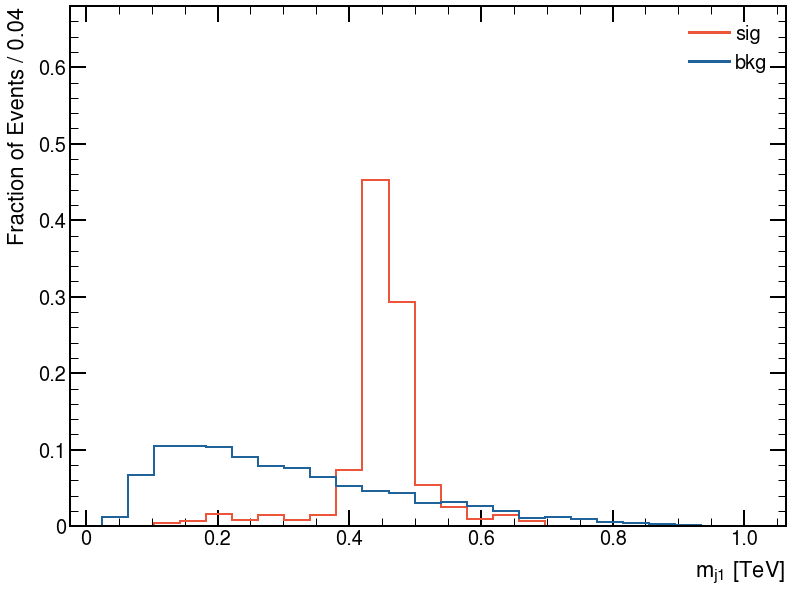

In [52]:
plotter.draw("m1", xlabel="$m_{j1}$ [TeV]")

[INFO] Using deduced bin range (0.000, 0.833)


<Axes: xlabel='$m_{j2}$ [TeV]', ylabel='Fraction of Events / 0.03'>

<Figure size 640x480 with 0 Axes>

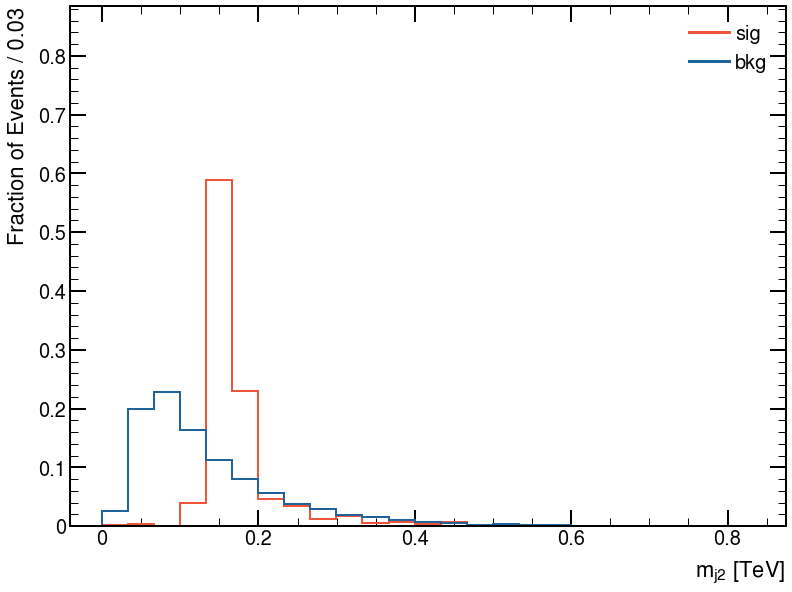

In [53]:
plotter.draw("m2", xlabel="$m_{j2}$ [TeV]")